In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
file_path = "earthquakes1.csv"
df = pd.read_csv(file_path)

In [5]:
df.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1970/01/04 17:00:40.20,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,1970/01/06 05:35:51.80,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,1970/01/08 17:12:39.10,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09
3,1970/01/10 12:07:08.60,6.825,126.737,73.0,6.1,Mb,91.0,NaN,NaN,0.0,NEI,1.970011e+09
4,1970/01/16 08:05:39.00,60.280,-152.660,85.0,6.0,ML,0.0,NaN,NaN,NaN,AK,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5304 entries, 0 to 5303
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DateTime    5304 non-null   object 
 1   Latitude    5304 non-null   float64
 2   Longitude   5304 non-null   float64
 3   Depth       5304 non-null   float64
 4   Magnitude   5304 non-null   float64
 5   MagType     5304 non-null   object 
 6   NbStations  5250 non-null   float64
 7   Gap         172 non-null    float64
 8   Distance    170 non-null    float64
 9   RMS         5264 non-null   float64
 10  Source      5304 non-null   object 
 11  EventID     5242 non-null   float64
dtypes: float64(9), object(3)
memory usage: 497.4+ KB


In [7]:
df.shape

(5304, 12)

In [8]:


# Drop columns with excessive missing values
df_cleaned = df.drop(columns=["Gap", "Distance", "EventID"])

# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# Convert DateTime to datetime object
df_cleaned["DateTime"] = pd.to_datetime(df_cleaned["DateTime"], errors="coerce")

# Extract time-based features
df_cleaned["Year"] = df_cleaned["DateTime"].dt.year
df_cleaned["Month"] = df_cleaned["DateTime"].dt.month
df_cleaned["Day"] = df_cleaned["DateTime"].dt.day

df_cleaned = df_cleaned.drop(columns=["DateTime"])

# Convert categorical columns to numerical
df_cleaned = pd.get_dummies(df_cleaned, columns=["MagType", "Source"], drop_first=True)

# Classify magnitude into categories
df_cleaned["Magnitude_Class"] = pd.cut(df_cleaned["Magnitude"], bins=[0, 5, 7, 10], labels=[0, 1, 2])
df_cleaned = df_cleaned.drop(columns=["Magnitude"])

# Define features and target variable
X = df_cleaned.drop(columns=["Magnitude_Class"])
y = df_cleaned["Magnitude_Class"].astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Print results
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1:.2%}")

Accuracy: 92.03%
Precision: 84.87%
Recall: 92.03%
F1-Score: 88.31%


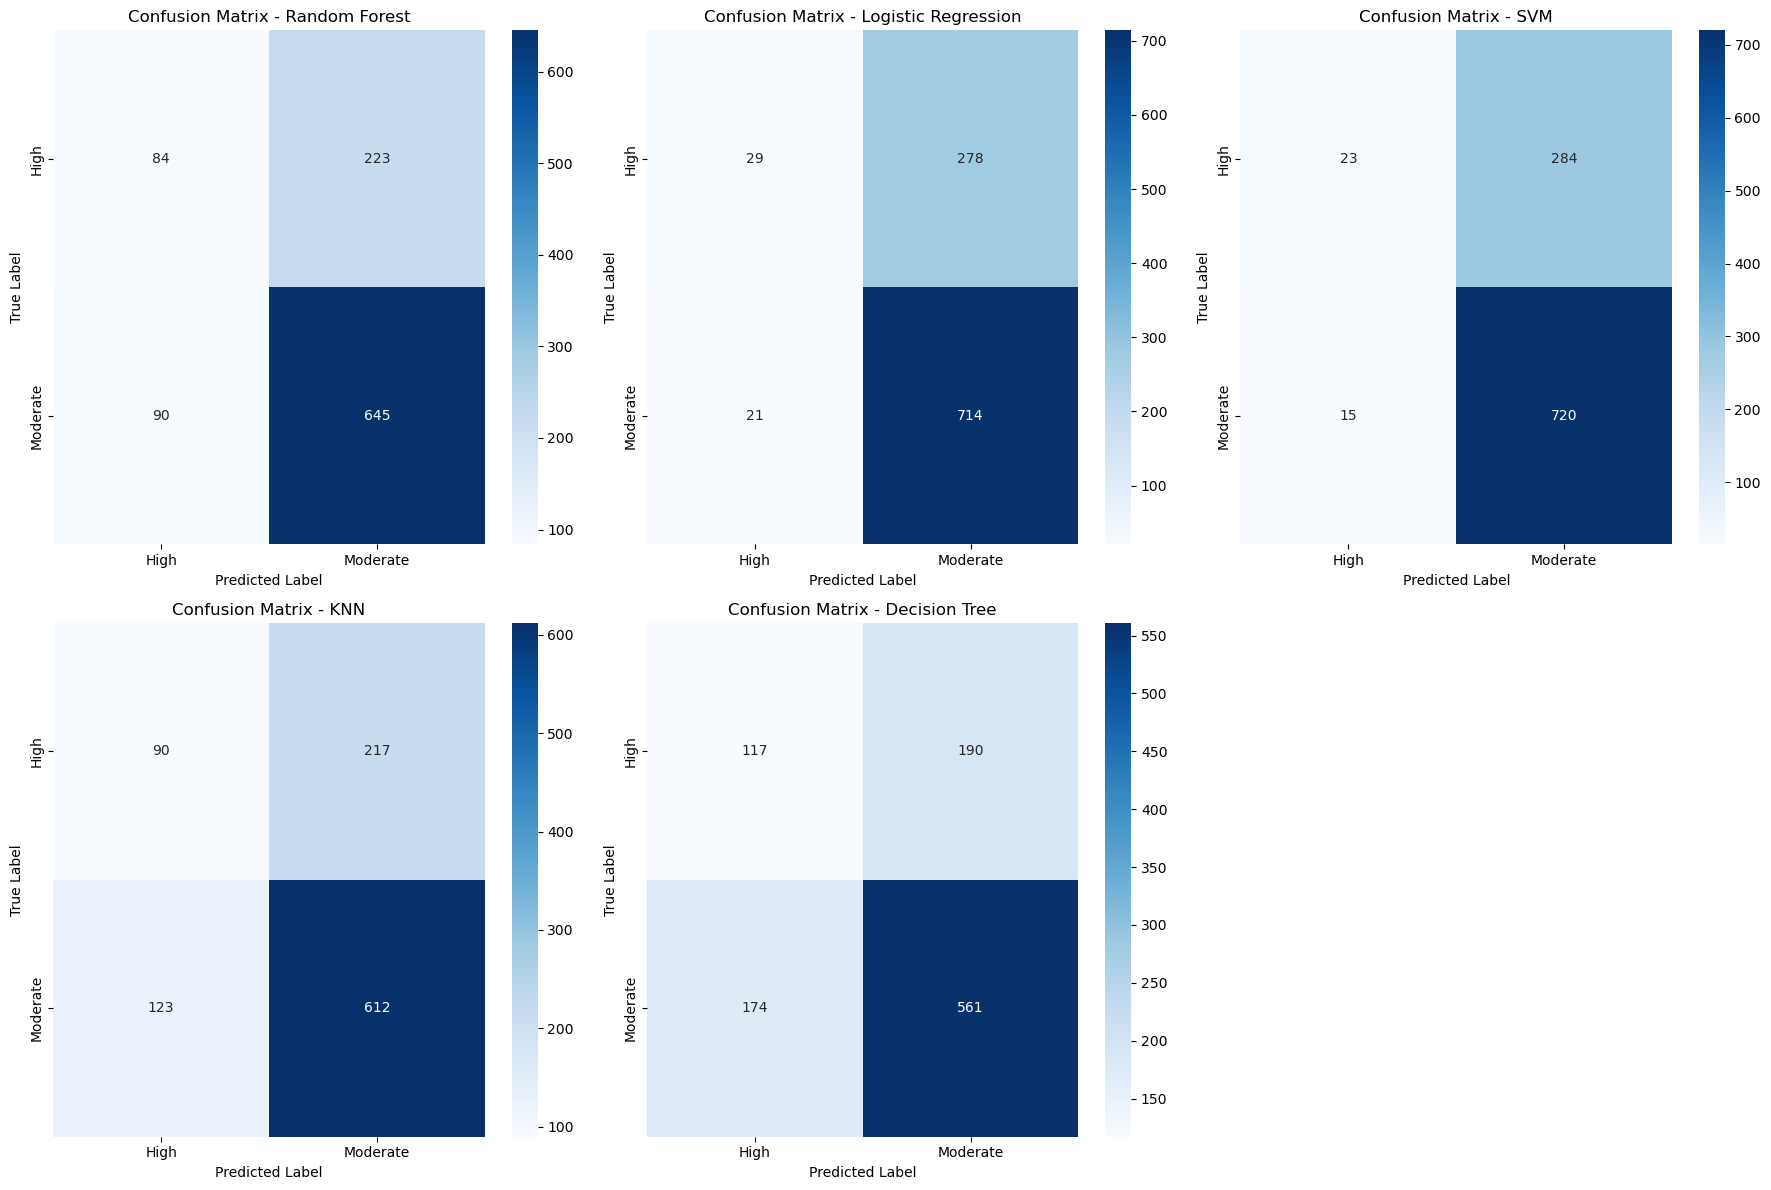

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Load dataset
file_path = "earthquakes1.csv"
df = pd.read_csv(file_path)

# Define earthquake severity levels
def categorize_magnitude(mag):
    if mag < 5.0:
        return "Low"
    elif 5.0 <= mag < 6.5:
        return "Moderate"
    else:
        return "High"

# Apply categorization
df["Severity"] = df["Magnitude"].apply(categorize_magnitude)

# Encode labels
label_encoder = LabelEncoder()
df["Severity"] = label_encoder.fit_transform(df["Severity"])

# Select features and target
features = ["Latitude", "Longitude", "Depth", "NbStations", "RMS"]
df_clean = df.dropna(subset=features + ["Severity"])  # Remove rows with missing values
X = df_clean[features]
y = df_clean["Severity"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Train models and generate confusion matrices
conf_matrices = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Creates 6 subplots
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    axes[i].set_title(f"Confusion Matrix - {name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

# Hide the unused last subplot
if len(conf_matrices) < len(axes):
    for j in range(len(conf_matrices), len(axes)):
        fig.delaxes(axes[j])  # Remove the extra subplot

plt.tight_layout()
plt.show()



Random Forest Results:
Accuracy: 92.03%
Precision: 84.87%
Recall: 92.03%
F1-Score: 88.31%



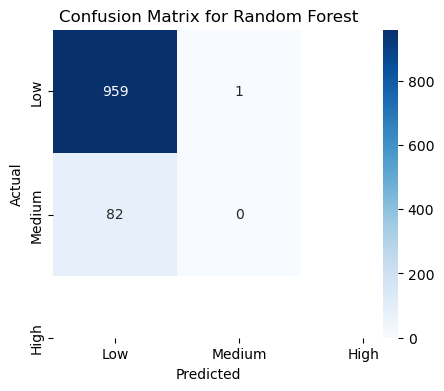

c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Accuracy: 91.84%
Precision: 84.86%
Recall: 91.84%
F1-Score: 88.21%



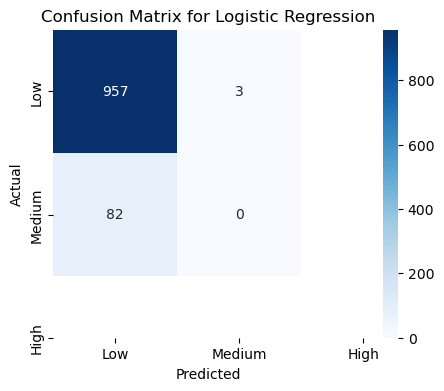

c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Results:
Accuracy: 92.13%
Precision: 84.88%
Recall: 92.13%
F1-Score: 88.36%



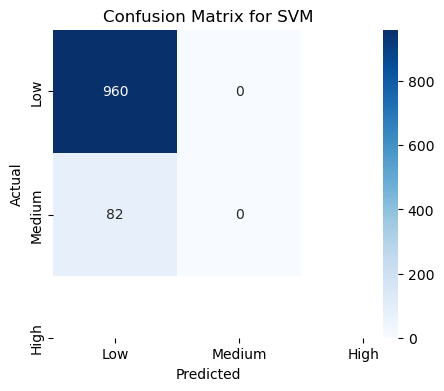

KNN Results:
Accuracy: 91.84%
Precision: 88.26%
Recall: 91.84%
F1-Score: 89.02%



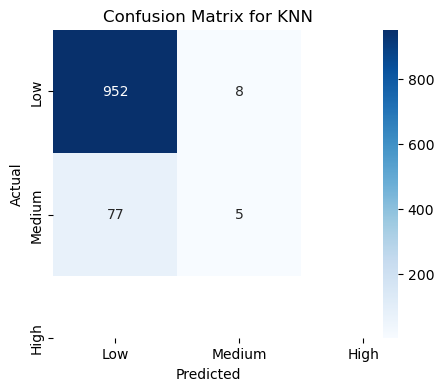

Decision Tree Results:
Accuracy: 86.95%
Precision: 87.78%
Recall: 86.95%
F1-Score: 87.35%



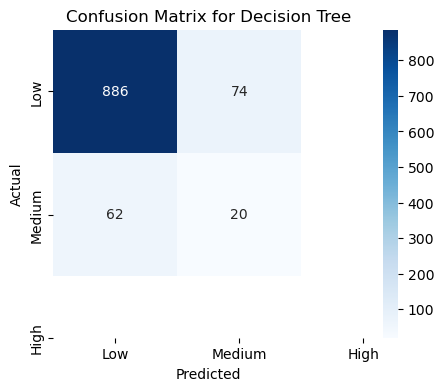

Naive Bayes Results:
Accuracy: 24.95%
Precision: 91.35%
Recall: 24.95%
F1-Score: 30.48%



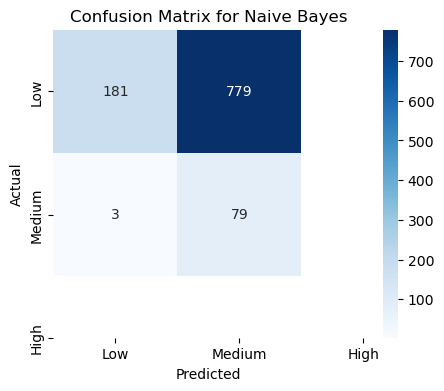

Skipping ROC curve for Naive Bayes due to shape mismatch.


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Load dataset
file_path = "earthquakes1.csv"
df = pd.read_csv(file_path)

# Drop columns with excessive missing values
df_cleaned = df.drop(columns=["Gap", "Distance", "EventID"])

# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# Convert DateTime to datetime object
df_cleaned["DateTime"] = pd.to_datetime(df_cleaned["DateTime"], errors="coerce")

# Extract time-based features
df_cleaned["Year"] = df_cleaned["DateTime"].dt.year
df_cleaned["Month"] = df_cleaned["DateTime"].dt.month
df_cleaned["Day"] = df_cleaned["DateTime"].dt.day

df_cleaned = df_cleaned.drop(columns=["DateTime"])

# Convert categorical columns to numerical
df_cleaned = pd.get_dummies(df_cleaned, columns=["MagType", "Source"], drop_first=True)

# Classify magnitude into categories
df_cleaned["Magnitude_Class"] = pd.cut(df_cleaned["Magnitude"], bins=[0, 5, 7, 10], labels=[0, 1, 2])
df_cleaned = df_cleaned.drop(columns=["Magnitude"])

# Define features and target variable
X = df_cleaned.drop(columns=["Magnitude_Class"])
y = df_cleaned["Magnitude_Class"].astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}\n")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    
    # ROC Curve
    # ROC Curve
if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_pred_prob = model.predict_proba(X_test)

    # Ensure y_test_bin has the same number of classes as y_pred_prob
    if y_test_bin.shape[1] == y_pred_prob.shape[1]:
        plt.figure()
        for i in range(y_test_bin.shape[1]):  # Iterate over each class
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"Skipping ROC curve for {name} due to shape mismatch.")


    

Random Forest Results:
Accuracy: 77.06%
Precision: 70.81%
Recall: 77.06%
F1-Score: 71.14%



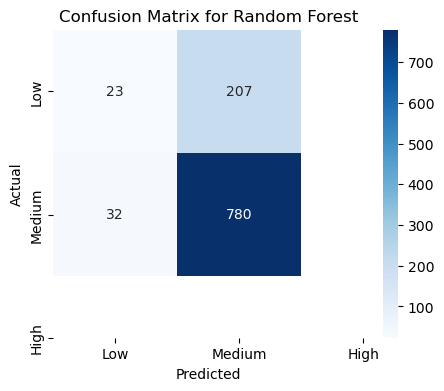

[[ 23 207]
 [ 32 780]]
Skipping ROC curve for Random Forest: Not all classes present in y_test.



c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Accuracy: 77.16%
Precision: 69.78%
Recall: 77.16%
F1-Score: 70.05%



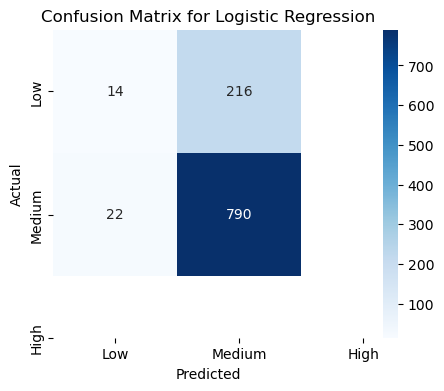

[[ 14 216]
 [ 22 790]]
Skipping ROC curve for Logistic Regression: Not all classes present in y_test.



c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Results:
Accuracy: 77.93%
Precision: 60.73%
Recall: 77.93%
F1-Score: 68.26%



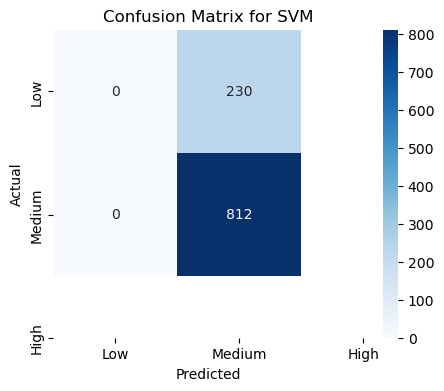

[[  0 230]
 [  0 812]]
Skipping ROC curve for SVM: Not all classes present in y_test.

KNN Results:
Accuracy: 75.05%
Precision: 68.51%
Recall: 75.05%
F1-Score: 70.28%



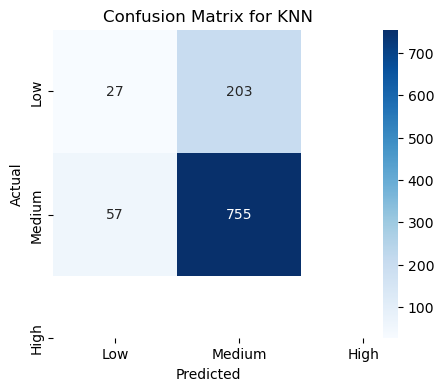

[[ 27 203]
 [ 57 755]]
Skipping ROC curve for KNN: Not all classes present in y_test.

Decision Tree Results:
Accuracy: 68.04%
Precision: 69.26%
Recall: 68.04%
F1-Score: 68.62%



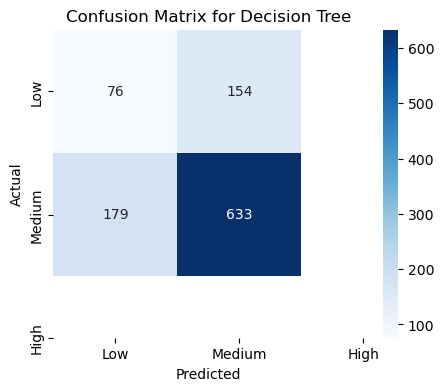

[[ 76 154]
 [179 633]]
Skipping ROC curve for Decision Tree: Not all classes present in y_test.

Naive Bayes Results:
Accuracy: 22.36%
Precision: 54.43%
Recall: 22.36%
F1-Score: 9.24%



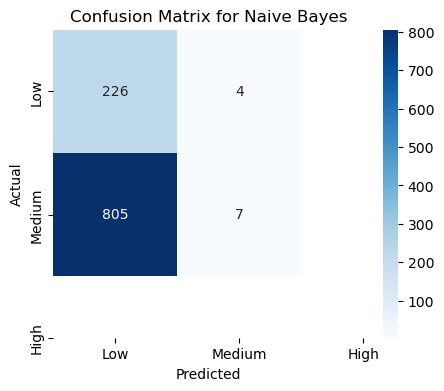

[[226   4]
 [805   7]]
Skipping ROC curve for Naive Bayes: Not all classes present in y_test.



In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Load dataset
file_path = "earthquakes1.csv"
df = pd.read_csv(file_path)

# Drop columns with excessive missing values
df_cleaned = df.drop(columns=["Gap", "Distance", "EventID"])

# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# Convert DateTime to datetime object
df_cleaned["DateTime"] = pd.to_datetime(df_cleaned["DateTime"], errors="coerce")

# Extract time-based features
df_cleaned["Year"] = df_cleaned["DateTime"].dt.year
df_cleaned["Month"] = df_cleaned["DateTime"].dt.month
df_cleaned["Day"] = df_cleaned["DateTime"].dt.day

df_cleaned = df_cleaned.drop(columns=["DateTime"])

# Convert categorical columns to numerical
df_cleaned = pd.get_dummies(df_cleaned, columns=["MagType", "Source"], drop_first=True)

# Classify magnitude into categories
df_cleaned["Magnitude_Class"] = pd.cut(df_cleaned["Magnitude"], bins=[0, 4, 6, 10], labels=[0, 1, 2])
df_cleaned = df_cleaned.drop(columns=["Magnitude"])

# Define features and target variable
X = df_cleaned.drop(columns=["Magnitude_Class"])
y = df_cleaned["Magnitude_Class"].astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, stratify=y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}\n")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print(cm)
    
    # ROC Curve
    if hasattr(model, "predict_proba") and callable(getattr(model, "predict_proba", None)):
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    # ✅ Ensure all classes exist in y_test before plotting
    
    if len(np.unique(y_test)) == 3:
        y_pred_prob = model.predict_proba(X_test)
        plt.figure()

        for i in range(3):  # 3 Classes: [0, 1, 2]
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.show()

    else:
        print(f"Skipping ROC curve for {name}: Not all classes present in y_test.\n")



Random Forest Results:
Accuracy: 92.03%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.92      1.00      0.96       960
        High       0.00      0.00      0.00        82

   micro avg       0.92      0.92      0.92      1042
   macro avg       0.64      0.67      0.65      1042
weighted avg       0.85      0.92      0.88      1042



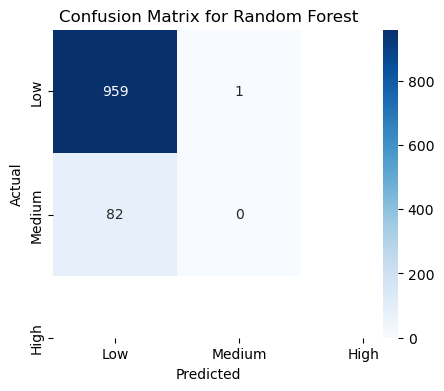

Skipping ROC curve for Random Forest due to shape mismatch.


c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Accuracy: 91.84%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.92      1.00      0.96       960
        High       0.00      0.00      0.00        82

   micro avg       0.92      0.92      0.92      1042
   macro avg       0.64      0.67      0.65      1042
weighted avg       0.85      0.92      0.88      1042



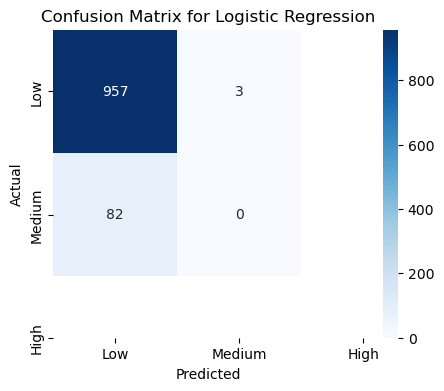

Skipping ROC curve for Logistic Regression due to shape mismatch.


c:\Users\Niraj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Results:
Accuracy: 92.13%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.92      1.00      0.96       960
        High       1.00      0.00      0.00        82

   micro avg       0.92      0.92      0.92      1042
   macro avg       0.97      0.67      0.65      1042
weighted avg       0.93      0.92      0.88      1042



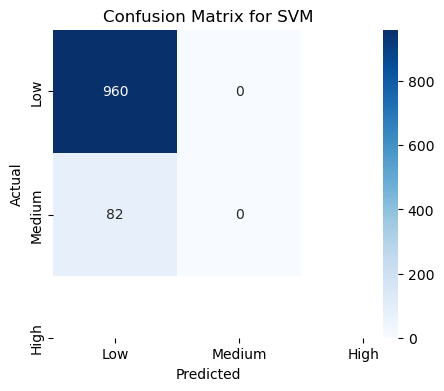

Skipping ROC curve for SVM due to shape mismatch.
KNN Results:
Accuracy: 91.84%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.93      0.99      0.96       960
        High       0.38      0.06      0.11        82

   micro avg       0.92      0.92      0.92      1042
   macro avg       0.77      0.68      0.69      1042
weighted avg       0.88      0.92      0.89      1042



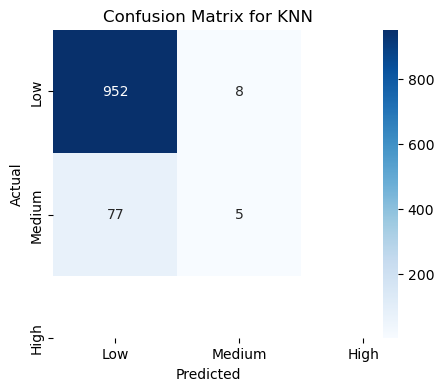

Skipping ROC curve for KNN due to shape mismatch.
Decision Tree Results:
Accuracy: 86.95%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.93      0.92      0.93       960
        High       0.21      0.24      0.23        82

   micro avg       0.87      0.87      0.87      1042
   macro avg       0.72      0.72      0.72      1042
weighted avg       0.88      0.87      0.87      1042



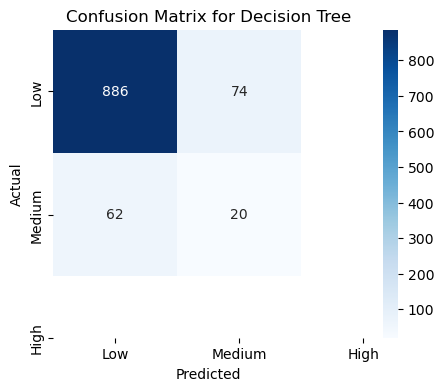

Skipping ROC curve for Decision Tree due to shape mismatch.
Naive Bayes Results:
Accuracy: 24.95%
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         0
      Medium       0.98      0.19      0.32       960
        High       0.09      0.96      0.17        82

   micro avg       0.25      0.25      0.25      1042
   macro avg       0.69      0.72      0.49      1042
weighted avg       0.91      0.25      0.30      1042



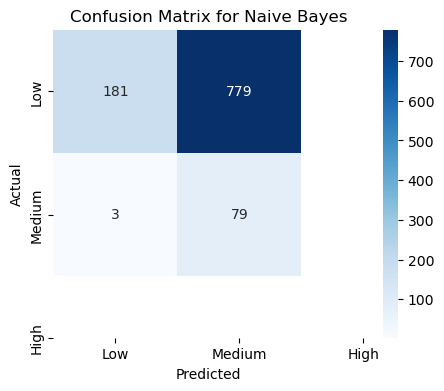

Skipping ROC curve for Naive Bayes due to shape mismatch.

Model Performance Summary:
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.920345   0.848734 0.920345  0.883090
Logistic Regression  0.918426   0.848594 0.918426  0.882130
                SVM  0.921305   0.848803 0.921305  0.883569
                KNN  0.918426   0.882631 0.918426  0.890217
      Decision Tree  0.869482   0.877795 0.869482  0.873521
        Naive Bayes  0.249520   0.913530 0.249520  0.304759


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# Load dataset
file_path = "earthquakes1.csv"
df = pd.read_csv(file_path)

# Drop columns with excessive missing values
df_cleaned = df.drop(columns=["Gap", "Distance", "EventID"])

# Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# Convert DateTime to datetime object
df_cleaned["DateTime"] = pd.to_datetime(df_cleaned["DateTime"], errors="coerce")

# Extract time-based features
df_cleaned["Year"] = df_cleaned["DateTime"].dt.year
df_cleaned["Month"] = df_cleaned["DateTime"].dt.month
df_cleaned["Day"] = df_cleaned["DateTime"].dt.day

df_cleaned = df_cleaned.drop(columns=["DateTime"])

# Convert categorical columns to numerical
df_cleaned = pd.get_dummies(df_cleaned, columns=["MagType", "Source"], drop_first=True)

# Classify magnitude into categories
df_cleaned["Magnitude_Class"] = pd.cut(df_cleaned["Magnitude"], bins=[0, 5, 7, 10], labels=[0, 1, 2])
df_cleaned = df_cleaned.drop(columns=["Magnitude"])

# Define features and target variable
X = df_cleaned.drop(columns=["Magnitude_Class"])
y = df_cleaned["Magnitude_Class"].astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Store results
results = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    results.append([name, accuracy, precision, recall, f1])
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.2%}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=["Low", "Medium", "High"], zero_division=1))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    
    # ROC Curve
    if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        y_pred_prob = model.predict_proba(X_test)
        if y_test_bin.shape[1] == y_pred_prob.shape[1]:
            plt.figure()
            for i in range(y_test_bin.shape[1]):  # Iterate over each class
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')
            
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name}')
            plt.legend(loc='lower right')
            plt.show()
        else:
            print(f"Skipping ROC curve for {name} due to shape mismatch.")

# Convert results to DataFrame and display as a table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))
